<a href="https://www.kaggle.com/code/mattspotify2023/is-100-test-accuracy-fake-please-check?scriptVersionId=211283316" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
!pip install ultralytics torchsummary

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import torch 
import os
import torchvision
from torchvision import datasets,transforms,models
from torch.utils.data import DataLoader,Dataset
import cv2
from ultralytics import YOLO
import torch.nn as nn
import torch.optim as optim

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
os.chdir('/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/train')

In [6]:
for file in os.listdir():
    print(file)

Inclusion
Rolled
Pitted
Scratches
Patches
Crazing


In [7]:
image = cv2.imread('/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/train/Rolled/RS_126.bmp')

In [8]:
import matplotlib.pyplot as plt

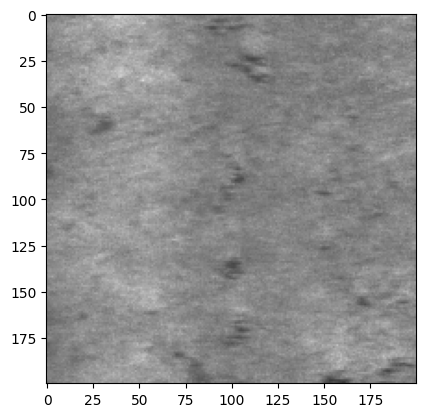

In [9]:
plt.imshow(image)

This should be simple case of image classification

In [10]:
from torchvision.datasets import ImageFolder

In [11]:
train_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/train'
valid_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid'
test_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test'

In [12]:
transformer_func = transforms.Compose([transforms.ToTensor()])

In [14]:
train_data = ImageFolder(root = train_dir,transform=transformer_func)
valid_data = ImageFolder(root = valid_dir,transform=transformer_func)
test_data = ImageFolder(root = valid_dir,transform=transformer_func)

In [15]:
train_loader = DataLoader(train_data,batch_size=32,num_workers=4,shuffle=True)
valid_loader = DataLoader(valid_data,batch_size=32,num_workers=4,shuffle=True)
test_loader = DataLoader(test_data,batch_size=32,num_workers=4,shuffle=True)

In [16]:
for data,labels in train_loader:
    print(labels.shape)
    print(data.shape)
    break

torch.Size([32])
torch.Size([32, 3, 200, 200])


In [17]:
train_data.class_to_idx

{'Crazing': 0,
 'Inclusion': 1,
 'Patches': 2,
 'Pitted': 3,
 'Rolled': 4,
 'Scratches': 5}

In [18]:
#Creating a simple NN
class linearNN(nn.Module):
    def __init__(self):
        super(linearNN,self).__init__()
        # self.flatten = nn.Flatten()
        self.linear_nn = nn.Sequential(
        
            nn.Linear(120000,512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Linear(128,6)
        )
    def forward(self,x):
        x = x.view(x.size(0),-1)
        return self.linear_nn(x)

In [19]:
class CNNmodel(nn.Module):
    def __init__(self):
        super(CNNmodel,self).__init__()
        self.convlayer = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32,padding=1,kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.linearlayer = nn.Sequential(
            # nn.Flatten(),
            nn.Linear(23*23*128,128),
            nn.ReLU(),
            nn.Linear(128,6)
    )
    def forward(self,x):
        x = self.convlayer(x)
        x = x.view(x.size(0),-1)
        x = self.linearlayer(x)
        return x

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [22]:
model = CNNmodel().to(device)

In [23]:
from torchsummary import summary

summary(model,input_size=(3,200,200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 200, 200]             896
              ReLU-2         [-1, 32, 200, 200]               0
         MaxPool2d-3         [-1, 32, 100, 100]               0
            Conv2d-4           [-1, 64, 98, 98]          18,496
              ReLU-5           [-1, 64, 98, 98]               0
         MaxPool2d-6           [-1, 64, 49, 49]               0
            Conv2d-7          [-1, 128, 47, 47]          73,856
              ReLU-8          [-1, 128, 47, 47]               0
         MaxPool2d-9          [-1, 128, 23, 23]               0
           Linear-10                  [-1, 128]       8,667,264
             ReLU-11                  [-1, 128]               0
           Linear-12                    [-1, 6]             774
Total params: 8,761,286
Trainable params: 8,761,286
Non-trainable params: 0
---------------------------

In [24]:
#testing if model and images work
for data,labels in train_loader:
    print(labels)
    y = (model(data.to(device)))
    y_pred = torch.argmax(torch.softmax(y,dim=1),dim=1)
    print(y_pred)
    break

tensor([2, 4, 5, 3, 0, 0, 3, 4, 2, 1, 4, 0, 3, 1, 3, 1, 5, 0, 5, 0, 0, 4, 0, 2, 1, 4, 1, 2, 3, 3, 4, 1])
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], device='cuda:0')


In [25]:
#hyperparams
epochs = 50
lre = 1e-04

In [26]:
optimizer = optim.Adam(model.parameters(),lr=lre)
loss_fn = nn.CrossEntropyLoss()

In [27]:
train_losses,test_losses = [],[]
train_accs,test_accs = [],[]
for epoch in range(epochs):
    model.train()
    train_loss,correct = 0,0
    for batch,(x,y) in enumerate(train_loader):
        x,y = x.to(device),y.to(device)
        pred = model(x)
        loss = loss_fn(pred,y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
        y_pred_class = torch.argmax(torch.softmax(pred,dim=1),dim=1)
        correct += (y_pred_class == y).sum().item()/len(pred)
    avg_loss = train_loss/len(train_loader)
    avg_acc = correct/len(train_loader)
    train_losses.append(avg_loss)
    train_accs.append(avg_acc)
    print(f'Epoch {epoch} | loss: {avg_loss} | accuracy: {avg_acc}')

    with torch.no_grad():
        model.eval()
        test_loss,test_acc = 0,0
        for batch,(x,y) in enumerate(valid_loader):
            x,y = x.to(device),y.to(device)
            pred = model(x)
            loss = loss_fn(pred,y)
            test_loss += loss.item()
            y_pred_class = torch.argmax(torch.softmax(pred,dim=1),dim=1)
            test_acc += (y_pred_class == y).sum().item()/len(pred)
    avg_loss = test_loss/len(valid_loader)
    avg_acc = test_acc/len(valid_loader)
    test_losses.append(avg_loss)
    test_accs.append(avg_acc)
    print(f'Epoch {epoch} | test loss: {avg_loss} | test accuracy: {avg_acc}')
        
        
        

Epoch 0 | loss: 1.60411049081729 | accuracy: 0.32431891025641024
Epoch 0 | test loss: 1.384657343228658 | test accuracy: 0.28125
Epoch 1 | loss: 1.1910976733152683 | accuracy: 0.6015625
Epoch 1 | test loss: 0.9704685211181641 | test accuracy: 0.78125
Epoch 2 | loss: 0.9243443768758041 | accuracy: 0.7003205128205128
Epoch 2 | test loss: 0.8315474390983582 | test accuracy: 0.65625
Epoch 3 | loss: 0.7135447756602213 | accuracy: 0.7704326923076923
Epoch 3 | test loss: 0.6278964281082153 | test accuracy: 0.8958333333333334
Epoch 4 | loss: 0.5547512890054629 | accuracy: 0.8185096153846154
Epoch 4 | test loss: 0.41077009836832684 | test accuracy: 0.8645833333333334
Epoch 5 | loss: 0.44615945793115175 | accuracy: 0.8609775641025641
Epoch 5 | test loss: 0.29234962662061054 | test accuracy: 0.96875
Epoch 6 | loss: 0.3773984834551811 | accuracy: 0.8798076923076923
Epoch 6 | test loss: 0.307899072766304 | test accuracy: 0.9375
Epoch 7 | loss: 0.31911254158386815 | accuracy: 0.8964342948717949
Epoc

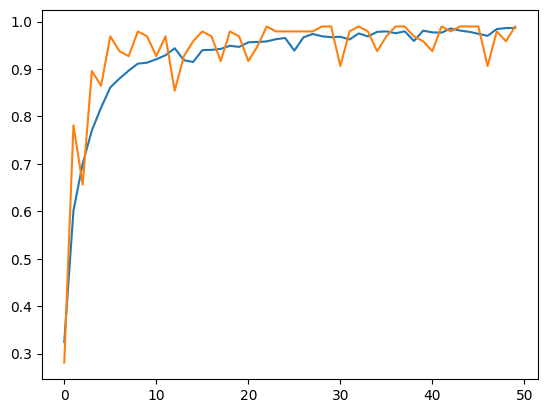

In [28]:
plt.plot(train_accs)
plt.plot(test_accs)

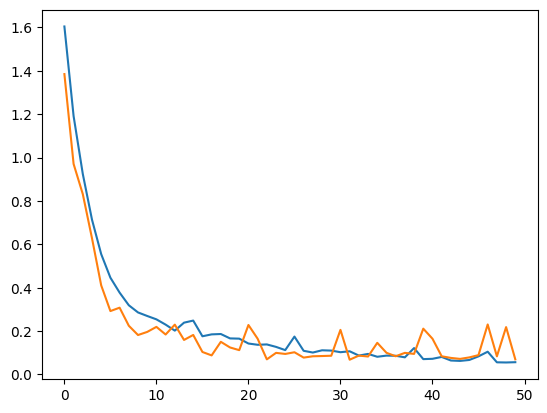

In [29]:
plt.plot(train_losses)
plt.plot(test_losses)

In [46]:
len(test_loader.dataset)

72

In [51]:
#Test accuracy
correct = 0
for data,labels in test_loader:
    y = (model(data.to(device)))
    y_pred = torch.argmax(torch.softmax(y,dim=1),dim=1)
    correct += (labels.to(device)==y_pred).sum().item()
    
CNN_test_accuracy = correct/len(test_loader.dataset)
print(f'Test accuracy is {CNN_test_accuracy:.3f}')

Test accuracy is 0.986


RESNET50 Fine tuning

In [52]:
tl_model = models.resnet50(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 196MB/s]


In [53]:
#This will stop updating weights
for param in tl_model.parameters():
    param.requires_grad = False

In [54]:
#Modify FCN
num_classes = 6
tl_model.avgpool=nn.AdaptiveAvgPool2d(output_size=(1,1))
input_tolinear = tl_model.fc.in_features
tl_model.fc =nn.Linear(input_tolinear,num_classes)
tl_model.to(device='cuda')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [55]:
from torchsummary import summary

summary(tl_model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [60]:
transformer_func = transforms.Compose([transforms.ToTensor(),transforms.Resize((224,224))])
train_data = ImageFolder(root = train_dir,transform=transformer_func)
valid_data = ImageFolder(root = valid_dir,transform=transformer_func)
test_data = ImageFolder(root = valid_dir,transform=transformer_func)
train_loader = DataLoader(train_data,batch_size=32,num_workers=4,shuffle=True)
valid_loader = DataLoader(valid_data,batch_size=32,num_workers=4)
test_loader = DataLoader(valid_data,batch_size=32,num_workers=4)

In [61]:
tl_optimizer = optim.Adam(tl_model.parameters(),lr=lre)
loss_fn = nn.CrossEntropyLoss()

In [62]:
epochs= 50

In [63]:
train_losses,test_losses = [],[]
train_accs,test_accs = [],[]
for epoch in range(epochs):
    tl_model.train()
    train_loss,correct = 0,0
    for batch,(x,y) in enumerate(train_loader):
        x,y = x.to(device),y.to(device)
        pred = tl_model(x)
        loss = loss_fn(pred,y)
        loss.backward()
        tl_optimizer.step()
        tl_optimizer.zero_grad()
        train_loss += loss.item()
        y_pred_class = torch.argmax(torch.softmax(pred,dim=1),dim=1)
        correct += (y_pred_class == y).sum().item()/len(pred)
    avg_loss = train_loss/len(train_loader)
    avg_acc = correct/len(train_loader)
    train_losses.append(avg_loss)
    train_accs.append(avg_acc)
    print(f'Epoch {epoch} | loss: {avg_loss} | accuracy: {avg_acc}')

    with torch.no_grad():
        tl_model.eval()
        test_loss,test_acc = 0,0
        for batch,(x,y) in enumerate(valid_loader):
            x,y = x.to(device),y.to(device)
            pred = tl_model(x)
            loss = loss_fn(pred,y)
            test_loss += loss.item()
            y_pred_class = torch.argmax(torch.softmax(pred,dim=1),dim=1)
            test_acc += (y_pred_class == y).sum().item()/len(pred)
    avg_loss = test_loss/len(valid_loader)
    avg_acc = test_acc/len(valid_loader)
    test_losses.append(avg_loss)
    test_accs.append(avg_acc)
    print(f'Epoch {epoch} | test loss: {avg_loss} | test accuracy: {avg_acc}')
        
        
        

Epoch 0 | loss: 0.6936127153726724 | accuracy: 0.9346955128205128
Epoch 0 | test loss: 0.456776221593221 | test accuracy: 1.0
Epoch 1 | loss: 0.5179333182481619 | accuracy: 0.952323717948718
Epoch 1 | test loss: 0.318074236313502 | test accuracy: 1.0
Epoch 2 | loss: 0.4013714950818282 | accuracy: 0.9593349358974359
Epoch 2 | test loss: 0.23750858008861542 | test accuracy: 1.0
Epoch 3 | loss: 0.34780642562187636 | accuracy: 0.9595352564102565
Epoch 3 | test loss: 0.20668789247671762 | test accuracy: 1.0
Epoch 4 | loss: 0.3002998430568438 | accuracy: 0.9625400641025641
Epoch 4 | test loss: 0.15854704628388086 | test accuracy: 1.0
Epoch 5 | loss: 0.2592843407048629 | accuracy: 0.9697516025641026
Epoch 5 | test loss: 0.13070000956455866 | test accuracy: 1.0
Epoch 6 | loss: 0.23769241943955421 | accuracy: 0.9673477564102565
Epoch 6 | test loss: 0.11759975304206212 | test accuracy: 1.0
Epoch 7 | loss: 0.21156274083142096 | accuracy: 0.9667467948717949
Epoch 7 | test loss: 0.10497069110472997

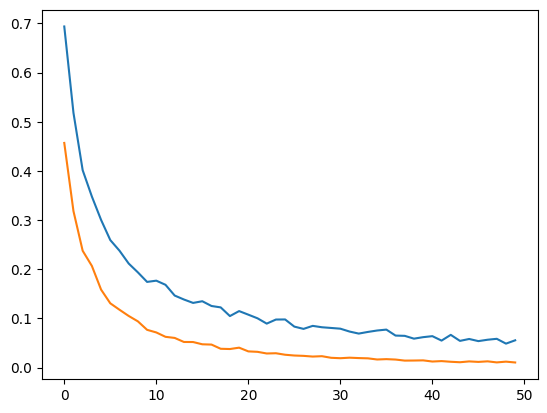

In [64]:
plt.plot(train_losses)
plt.plot(test_losses)

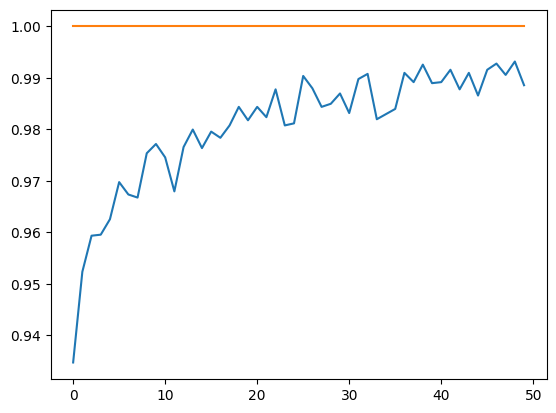

In [65]:
plt.plot(train_accs)
plt.plot(test_accs)

In [69]:
#Resnet test accuracy
correct = 0
for data,labels in test_loader:
    y = (tl_model(data.to(device)))
    y_pred = torch.argmax(torch.softmax(y,dim=1),dim=1)
    correct += (labels.to(device)==y_pred).sum().item()
    
resnet_test_accuracy = correct/len(test_loader.dataset)
resnet_test_accuracy
print(f'Resnet test accuracy is {resnet_test_accuracy:.3f}')

Resnet test accuracy is 1.000


ConvNext

In [62]:
device

'cuda'

In [64]:
for x,y in train_loader:
    print(x.to('cuda'))
    break

tensor([[[[0.8745, 0.8235, 0.8627,  ..., 0.8588, 0.8431, 0.8353],
          [0.8588, 0.8549, 0.8863,  ..., 0.8863, 0.8549, 0.8353],
          [0.8392, 0.8784, 0.9020,  ..., 0.8667, 0.8431, 0.8196],
          ...,
          [0.9569, 0.9294, 0.9020,  ..., 0.7333, 0.7294, 0.7843],
          [0.9294, 0.9176, 0.8431,  ..., 0.7451, 0.7255, 0.8392],
          [0.8863, 0.8392, 0.8196,  ..., 0.8000, 0.7686, 0.8392]],

         [[0.8745, 0.8235, 0.8627,  ..., 0.8588, 0.8431, 0.8353],
          [0.8588, 0.8549, 0.8863,  ..., 0.8863, 0.8549, 0.8353],
          [0.8392, 0.8784, 0.9020,  ..., 0.8667, 0.8431, 0.8196],
          ...,
          [0.9569, 0.9294, 0.9020,  ..., 0.7333, 0.7294, 0.7843],
          [0.9294, 0.9176, 0.8431,  ..., 0.7451, 0.7255, 0.8392],
          [0.8863, 0.8392, 0.8196,  ..., 0.8000, 0.7686, 0.8392]],

         [[0.8745, 0.8235, 0.8627,  ..., 0.8588, 0.8431, 0.8353],
          [0.8588, 0.8549, 0.8863,  ..., 0.8863, 0.8549, 0.8353],
          [0.8392, 0.8784, 0.9020,  ..., 0

In [83]:
convmodel = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.DEFAULT)
# convmodel = convmodel.to(device)

In [84]:
num_classes = 6
num_ftrs = convmodel.classifier[2].in_features
convmodel.classifier[2] = nn.Linear(num_ftrs,num_classes)

In [85]:
convmodel = convmodel.to(device)

In [86]:
from torchsummary import summary

summary(convmodel,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]           4,704
       LayerNorm2d-2           [-1, 96, 56, 56]             192
            Conv2d-3           [-1, 96, 56, 56]           4,800
           Permute-4           [-1, 56, 56, 96]               0
         LayerNorm-5           [-1, 56, 56, 96]             192
            Linear-6          [-1, 56, 56, 384]          37,248
              GELU-7          [-1, 56, 56, 384]               0
            Linear-8           [-1, 56, 56, 96]          36,960
           Permute-9           [-1, 96, 56, 56]               0
  StochasticDepth-10           [-1, 96, 56, 56]               0
          CNBlock-11           [-1, 96, 56, 56]               0
           Conv2d-12           [-1, 96, 56, 56]           4,800
          Permute-13           [-1, 56, 56, 96]               0
        LayerNorm-14           [-1, 56,

In [77]:
#This will stop updating weights
for param in convmodel.parameters():
    param.requires_grad = False

In [87]:
cn_optimizer = optim.Adam(convmodel.parameters(),lr=1e-04)
loss_fn = nn.CrossEntropyLoss()
epochs= 50

In [95]:
len(train_loader)

52

In [96]:
train_losses,test_losses = [],[]
train_accs,test_accs = [],[]
for epoch in range(epochs):
    convmodel.train()
    train_loss,correct = 0,0
    for batch,(x,y) in enumerate(train_loader):
        x,y = x.to(device),y.to(device)
        pred = convmodel(x)
        loss = loss_fn(pred,y)
        loss.backward()
        cn_optimizer.step()
        cn_optimizer.zero_grad()
        train_loss += loss.item()
        y_pred_class = torch.argmax(torch.softmax(pred,dim=1),dim=1)
        correct += (y_pred_class == y).sum().item()
    avg_loss = train_loss/len(train_loader)
    avg_acc = correct/len(train_loader.dataset)
    train_losses.append(avg_loss)
    train_accs.append(avg_acc)
    print(f'Epoch {epoch} | loss: {avg_loss} | accuracy: {avg_acc}')

    with torch.no_grad():
        convmodel.eval()
        test_loss,test_acc = 0,0
        for batch,(x,y) in enumerate(valid_loader):
            x,y = x.to(device),y.to(device)
            pred = convmodel(x)
            loss = loss_fn(pred,y)
            test_loss += loss.item()
            y_pred_class = torch.argmax(torch.softmax(pred,dim=1),dim=1)
            test_acc += (y_pred_class == y).sum().item()
        avg_loss = test_loss/len(valid_loader)
        avg_acc = test_acc/len(valid_loader.dataset)
        test_losses.append(avg_loss)
        test_accs.append(avg_acc)
        print(f'Epoch {epoch} | test loss: {avg_loss} | test accuracy: {avg_acc}')

Epoch 0 | loss: 0.0004280956966865163 | accuracy: 1.0
Epoch 0 | test loss: 0.00013636681978823617 | test accuracy: 1.0
Epoch 1 | loss: 0.0003559349122672127 | accuracy: 1.0
Epoch 1 | test loss: 9.446803354270135e-05 | test accuracy: 1.0
Epoch 2 | loss: 0.0003491458589381252 | accuracy: 1.0
Epoch 2 | test loss: 8.178476370327796e-05 | test accuracy: 1.0
Epoch 3 | loss: 0.0002671818018335706 | accuracy: 1.0
Epoch 3 | test loss: 6.966820365050808e-05 | test accuracy: 1.0
Epoch 4 | loss: 0.0002794995003708979 | accuracy: 1.0
Epoch 4 | test loss: 5.866470504164075e-05 | test accuracy: 1.0


In [102]:
#testing if model and images work
for data,labels in test_loader:
    y = (convmodel(data.to(device)))
    y_pred = torch.argmax(torch.softmax(y,dim=1),dim=1)
    print(labels)
    print(y_pred)
    
    break

tensor([4, 4, 1, 2, 2, 3, 0, 5, 3, 1, 4, 0, 4, 0, 3, 5, 1, 3, 2, 0, 2, 4, 3, 2, 2, 1, 4, 2, 1, 5, 2, 5])
tensor([4, 4, 1, 2, 2, 3, 0, 5, 3, 1, 4, 0, 4, 0, 3, 5, 1, 3, 2, 0, 2, 4, 3, 2, 2, 1, 4, 2, 1, 5, 2, 5], device='cuda:0')
